In [132]:
import sys
import re
import pandas as pd
from os import walk
from pathlib import Path
from functools import reduce
from tabulate import tabulate

In [133]:
ROOT_PATH = "/Users/janschill/code/rails/rails"

In [134]:
def full_path(file_name):
    return ROOT_PATH + file_name

In [135]:
# Number of lines
def number_of_lines(file):
    return sum([1 for line in open(file)])

In [136]:
def extract_from_line(name, line):
    if re.search("^([\s]*#)", line): # ignore comments
        return None
    elif name == 'def|end':
        method = re.search("^([\s]*(def |end)[ (\S+)]*)", line)
        return str(method.group(1)) if method else None
    elif name == 'module|class|end':
        namespace = re.search("^([\s]*(module|class|end)[ (\S+)]*)", line)
        return str(namespace.group(1)) if namespace else None
    else:
        x = re.search("" + name + " (\S+)", line)
        return None if x == None else str(x.group(1))

In [137]:
def extract(file, keyword, all_lines = False):
    extracts = []
    for line in open(file):
        extract = extract_from_line(keyword, line)
        if extract or all_lines:
            extracts.append(extract)
    return extracts

In [138]:
def extract_requires(file):
    return extract(file, 'requires')

def extract_modules(file):
    return extract(file, 'module')

def extract_classes(file):
    return extract(file, 'class')

In [139]:
def clean_namespace(namespace):
    return namespace.replace('module', '').replace('class', '').replace(' ', '')

def extract_namespace(file):
    namespaces = []
    namespace = []
    previous_identation = -1
    for line in open(file):
        extract = extract_from_line('module|class|end', line)
        if extract == None:
            continue
        else:
            if 'end' in extract and (len(extract) - len(extract.lstrip(' ')) == previous_identation):
                namespaces.append(namespace.copy())
            elif 'module' in extract or 'class' in extract:
                current_identation = len(extract) - len(extract.lstrip(' '))
                module_or_class = 'module' if 'module' in extract else 'class'
                current_namespace = clean_namespace(extract)    
                if current_identation > previous_identation:
                    namespace.append(current_namespace)
                elif current_identation < previous_identation:
                    del namespace[-1]
                    if len(namespace) > 0:
                        del namespace[-1]
                    namespace.append(current_namespace)
                else:
                    del namespace[-1]
                    namespace.append(current_namespace)
                previous_identation = current_identation
            else:
                continue
    return namespaces

In [140]:
def retrieve_function_name(func):
    function_name = re.search("def (\S+)", func)
    return function_name.group(1)

def add_function(function_name, line_count):
    return {
        'function_name': function_name,
        'line_count': line_count,
    }

# TODO: This does not do nested functions ATM
def extract_functions(file):
    functions = []
    line_count = 1
    current_function_name = ''
    def_identation = -1
    for ext in extract(file, 'def|end', True):
        if ext == None: # None, increment line_count
            line_count += 1
        else:
            identation = len(ext) - len(ext.lstrip(' '))
            if 'def ' in ext and ' end' in ext:
                current_function_name = retrieve_function_name(ext)
                functions.append(add_function(current_function_name, 1))
            elif 'def ' in ext:
                def_identation = identation
                line_count = 0
                current_function_name = retrieve_function_name(ext)
            elif 'end' in ext and identation == def_identation:
                functions.append(add_function(current_function_name, line_count))
                current_function_name = ''
                line_count = 1
            else:
                line_count += 1
    return functions

In [141]:
def number_of(file, keyword):
    return sum([1 for line in open(file) if extract_from_line(keyword, line)])

def number_of_modules(file):
    return number_of(file, 'module')

def number_of_functions(file):
    return number_of(file, 'def')

def number_of_requires(file):
    return number_of(file, 'require')

In [142]:
# Add all directories from repo root
directories = []
for (dirpath, dirnames, filenames) in walk(ROOT_PATH):
    directories.extend(dirnames)
    break
directories = list(filter(lambda x: x[0] != ".", directories)) # don't use hidden dirs

## Add information to files

In [143]:
def get_files(path, file_extension):
    files = Path(path).rglob("*." + file_extension)
    meta_data_files = []
    for file in files:
        meta_data_files.append({
            'filename': str(file),
            'no_lines': number_of_lines(file),
            'no_modules': number_of_modules(file),
            'no_functions': number_of_functions(file),
            'functions': extract_functions(file),
            'no_requires': len(extract_requires(file)),
            'requires': extract_requires(file),
            'namespace': extract_namespace(file)
        })
    return meta_data_files

In [144]:
def reduce_by_key(list, key):
    sum = 0
    for el in list:
        sum = sum + el[key]
    return sum

## Add information to gems

In [145]:
rails_components = {}
for directory in directories:
    files = get_files(full_path('/' + directory + '/'), 'rb')
    average_LOC = int(reduce_by_key(files, 'no_lines') / len(files))
    average_NOF = int(reduce_by_key(files, 'no_functions') / len(files))
    average_requires = int(reduce_by_key(files, 'no_requires') / len(files))
    rails_components[directory] = {
        'files': files,
        'average_LOC': average_LOC,
        'average_NOF': average_NOF,
        'average_requires': average_requires }
rails_components = {k: v for k, v in sorted(rails_components.items(), key = lambda item: item[0])}

In [146]:
def print_rails_components():
    format = "{:<15}{:<1}{:<10}{:<1}{:<7}{:<1}{:<10}{:<1}{:<10}"
    print(format.format("Component", " | ", "Ruby files", " | ", "Ø LOC", " | ", "Ø Functions", " | ", "Ø Requires"))
    print('----------------+------------+---------+------------+-----------')
    for k, v in rails_components.items():
        print(format.format(k, ' | ' , len(v['files']), ' | ', v['average_LOC'], ' | ', v['average_NOF'], ' | ', v['average_requires']))

## Rails gems

In [147]:
print_rails_components()

Component       | Ruby files | Ø LOC   | Ø Functions | Ø Requires
----------------+------------+---------+------------+-----------
actioncable     | 86         | 79      | 6          | 0         
actionmailbox   | 93         | 34      | 1          | 0         
actionmailer    | 41         | 140     | 9          | 0         
actionpack      | 325        | 202     | 16         | 0         
actiontext      | 74         | 35      | 2          | 0         
actionview      | 186        | 231     | 18         | 0         
activejob       | 118        | 70      | 4          | 0         
activemodel     | 130        | 118     | 8          | 0         
activerecord    | 853        | 160     | 12         | 0         
activestorage   | 124        | 62      | 3          | 0         
activesupport   | 469        | 119     | 10         | 0         
ci              | 1          | 22      | 0          | 0         
guides          | 22         | 69      | 3          | 0         
railties        | 278   

## Lines of code

In [148]:
def rails_loc():
    RAILS_LOC = 0
    for k,v in rails_components.items():
        for file in v['files']:
            RAILS_LOC += file['no_lines']
    return RAILS_LOC

In [161]:
def data_frame_loc():
    components = {}
    no_functions = 0
    for k,v in rails_components.items():
        components[k] = 0
        for file in v['files']:
            components[k] += file['no_lines']
            no_functions += file['no_functions']
        rails_components[k]['no_lines'] = components[k] # add total LOC of gem to dic.
        rails_components[k]['no_functions'] = no_functions # add total no. of functions of gem to dic.
        no_functions = 0
    components = {k: v for k, v in sorted(components.items(), key=lambda item: item[1], reverse=True)}
    return components

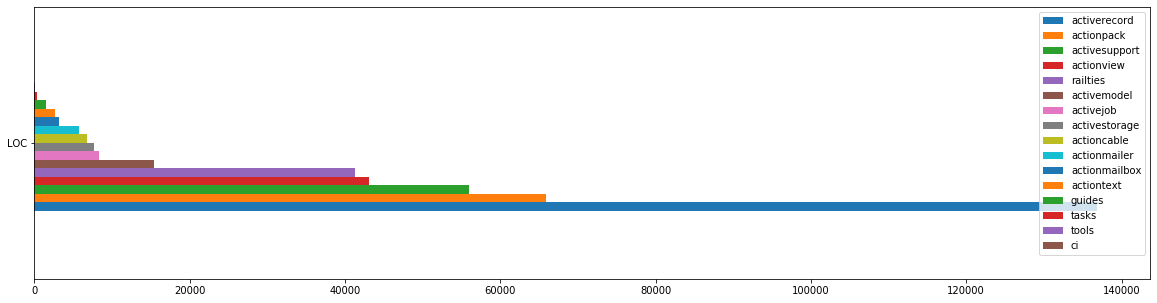

In [156]:
RAILS_LOC = rails_loc()
data_frame_loc = data_frame_loc()

df = pd.DataFrame(data_frame_loc, index=['LOC'])
ax = df.plot.barh(figsize=(20,5))

In [164]:
format = "{:<15}{:<1}{:<6}{:<1}{:<6}"
print(format.format('Component', ' | ', 'LOC', ' | ', 'NOF'))
print('----------------+--------+--------')
for k, v in rails_components.items():
    print(format.format(k, ' | ' , v['no_lines'], ' | ' , v['no_functions']))

Component       | LOC    | NOF   
----------------+--------+--------
actioncable     | 6846   | 535   
actionmailbox   | 3170   | 144   
actionmailer    | 5742   | 369   
actionpack      | 65919  | 5289  
actiontext      | 2625   | 174   
actionview      | 43045  | 3474  
activejob       | 8265   | 559   
activemodel     | 15441  | 1071  
activerecord    | 136860 | 10949 
activestorage   | 7710   | 389   
activesupport   | 56011  | 4714  
ci              | 22     | 0     
guides          | 1534   | 87    
railties        | 41328  | 2653  
tasks           | 323    | 5     
tools           | 43     | 2     


In [158]:
def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')

In [159]:
format = "{:<35}{:<1}{:<7}{:<1}{:<5}{:<1}{:<5}{:<1}"
print(format.format('Component', ' | ', 'LOC', ' | ', 'NOF', ' | ', 'NOR', ' | '))
print('-------------------------------------+--------+-------+-------|')
for k, v in rails_components.items():
    print(format.format(k, ' | ', rails_components[k]['no_lines'], ' | ', rails_components[k]['no_functions'], ' | ', '', ' | '))
    print('-------------------------------------+--------+-------+-------|')
    files = sorted(v['files'], key=lambda k: k['no_lines'], reverse=True)
    for f in files:
        print(format.format(get_filename(f['filename']), ' | ', f['no_lines'], ' | ', f['no_functions'], ' | ', f['no_requires'], ' | '))
    print('------------------------------------+--------+--------+--------|')

Component                           | LOC     | NOF   | NOR   | 
-------------------------------------+--------+-------+-------|
actioncable                         | 6846    | 535   |       | 
-------------------------------------+--------+-------+-------|
stream_test                         | 372     | 13    | 0     | 
client_test                         | 314     | 24    | 0     | 
test_case                           | 310     | 24    | 0     | 
base_test                           | 282     | 17    | 0     | 
base                                | 266     | 28    | 0     | 
test_case                           | 234     | 12    | 0     | 
base                                | 222     | 24    | 0     | 
test_case_test                      | 214     | 28    | 0     | 
streams                             | 202     | 13    | 0     | 
test_case_test                      | 197     | 26    | 0     | 
redis                               | 180     | 18    | 0     | 
client_socket              

In [160]:
def remove_root_path(path):
    return path.replace(ROOT_PATH + '/', '')

def remove_module_path(path, module):
    return path.replace(module, '')

def remove_filename(path):
    return path.replace(os.path.basename(os.path.normpath(path)), '')

def get_relative_path(path, module):
    return remove_module_path(remove_root_path(remove_filename(path)), module)

def get_filename(path):
    return os.path.basename(os.path.normpath(path)).replace('.rb', '')